# BipedalWalker with Twin Delayed DDPG (TD3)

### Paper: https://arxiv.org/abs/1802.09477


### 1. Start the Environment and Agent 

In [1]:
import numpy as np
import torch
import torch.nn as nn
#from torch.autograd import Variable
import torch.nn.functional as F

import gym
#import argparse
import os

import time
from TwinDelayed import Actor, Critic, ReplayBuffer, TD3
from collections import deque


device:  cuda


In [2]:
start_timestep=1e4

std_noise=0.1

env = gym.make('BipedalWalker-v3')

# Set seeds
seed = 88
env.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

state = env.reset()
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0] 
max_action = float(env.action_space.high[0])

agent = TD3(state_dim, action_dim, max_action)


/home/dan/anaconda3/envs/rl/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


### 2. Traning the agent

In [3]:
# save(agent = agent, filename='checkpnt, directory = 'dir_chkpoint')     
def save(agent, filename, directory):
    torch.save(agent.actor.state_dict(), '%s/%s_actor.pth' % (directory, filename))
    torch.save(agent.critic.state_dict(), '%s/%s_critic.pth' % (directory, filename))
    torch.save(agent.actor_target.state_dict(), '%s/%s_actor_t.pth' % (directory, filename))
    torch.save(agent.critic_target.state_dict(), '%s/%s_critic_t.pth' % (directory, filename))   

In [4]:
# Twin Delayed Deep Deterministic (TD3) policy gradient algorithm
def twin_ddd_train(n_episodes=2000, save_every=10):

    scores_deque = deque(maxlen=100)
    scores_array = []
    avg_scores_array = []    

    time_start = time.time()                    # Init start time
    replay_buf = ReplayBuffer()                 # Init ReplayBuffer
    
    timestep_after_last_save = 0
    total_timesteps = 0
    
    low = env.action_space.low
    high = env.action_space.high
    
    print('Low in action space: ', low, ', High: ', high, ', Action_dim: ', action_dim)
            
    for i_episode in range(1, n_episodes+1):
        
        timestep = 0
        total_reward = 0
        
        # Reset environment
        state = env.reset()
        done = False
        
        while True:
            
            # Select action randomly or according to policy
            if total_timesteps < start_timestep:
                action = env.action_space.sample()
            else:
                action = agent.select_action(np.array(state))
                if std_noise != 0: 
                    shift_action = np.random.normal(0, std_noise, size=action_dim)
                    action = (action + shift_action).clip(low, high)
            
            # Perform action
            new_state, reward, done, _ = env.step(action) 
            done_bool = 0 if timestep + 1 == env._max_episode_steps else float(done)
            total_reward += reward                          # full episode reward

            # Store every timestep in replay buffer
            replay_buf.add((state, new_state, action, reward, done_bool))
            state = new_state

            timestep += 1     
            total_timesteps += 1
            timestep_after_last_save += 1

            if done:                                       # done ?
                break                                      # save score

        scores_deque.append(total_reward)
        scores_array.append(total_reward)

        avg_score = np.mean(scores_deque)
        avg_scores_array.append(avg_score)
        
        # train_by_episode(time_start, i_episode) 
        s = (int)(time.time() - time_start)
        print('Ep. {}, Timestep {},  Ep.Timesteps {}, Score: {:.2f}, Avg.Score: {:.2f}, Time: {:02}:{:02}:{:02} '\
                .format(i_episode, total_timesteps, timestep, \
                        total_reward, avg_score, s//3600, s%3600//60, s%60))     

        agent.train(replay_buf, timestep)

        # Save episode if more than save_every=5000 timesteps
        if timestep_after_last_save >= save_every:

            timestep_after_last_save %= save_every            
            save(agent, 'checkpnt_seed_88', 'dir_chk')  
        
        if len(scores_deque) == 100 and np.mean(scores_deque) >= 300.5:
            print('Environment solved with Average Score: ',  np.mean(scores_deque) )
            break 

    return scores_array, avg_scores_array

scores, avg_scores = twin_ddd_train(n_episodes=10)

Low in action space:  [-1. -1. -1. -1.] , High:  [1. 1. 1. 1.] , Action_dim:  4
Ep. 1, Timestep 66,  Ep.Timesteps 66, Score: -102.01, Avg.Score: -102.01, Time: 00:00:00 
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size(

FileNotFoundError: [Errno 2] No such file or directory: 'dir_chk/checkpnt_seed_88_actor.pth'

In [5]:
save(agent, 'chpnt_88seed_300-5sc_9h44m', 'dir_chk')  

length of scores:  1795 , len of avg_scores:  1795


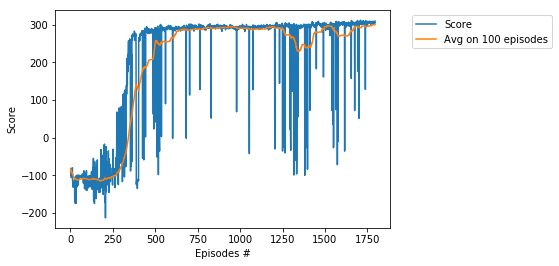

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

print('length of scores: ', len(scores), ', len of avg_scores: ', len(avg_scores))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label="Score")
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

In [7]:
from collections import deque
import os

def play(env, agent, n_episodes):
    state = env.reset()
    
    scores_deque = deque(maxlen=100)
    scores = []

    for i_episode in range(1, n_episodes+1):
        state = env.reset()        
        score = 0
        
        time_start = time.time()
        
        while True:
            action = agent.select_action(np.array(state))
            env.render()
            next_state, reward, done, _ = env.step(action)
            state = next_state
            score += reward
            if done:
                break 

        s = (int)(time.time() - time_start)
        
        scores_deque.append(score)
        scores.append(score)
        
        print('Episode {}\tAverage Score: {:.2f},\tScore: {:.2f} \tTime: {:02}:{:02}:{:02}'\
                  .format(i_episode, np.mean(scores_deque), score, s//3600, s%3600//60, s%60))  

play(env=env, agent=agent, n_episodes=7)


Episode 1	Average Score: 304.17,	Score: 304.17 	Time: 00:00:16
Episode 2	Average Score: 304.81,	Score: 305.44 	Time: 00:00:12
Episode 3	Average Score: 305.16,	Score: 305.87 	Time: 00:00:12
Episode 4	Average Score: 305.21,	Score: 305.34 	Time: 00:00:12
Episode 5	Average Score: 305.14,	Score: 304.86 	Time: 00:00:12
Episode 6	Average Score: 304.79,	Score: 303.05 	Time: 00:00:13
Episode 7	Average Score: 304.80,	Score: 304.90 	Time: 00:00:12


In [8]:
env.close()